<img src='./pic/SharifUniLogo.png' alt="SUT logo" width=300 height=300 align=left class="saturate" > <br>

<div dir=ltr align=center>
<font color=0F5298 size=7>
    Massive Data Mining <br>
<font color=000000 size=5>
    Electrical Engineering Department <br>
    Fall 2024 <br>
<font color=696080 size=5>
    Homework 1 - Spark Exercise <br>
<font color=696880 size=4>
    Behnam Raoufi
    
____

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

## Dataset Link
[Arxiv Dataset download link](https://drive.google.com/file/d/1-EhpZaY5gvbgNuEU5IskmlQ0EnNAG5cu/view?usp=drive_link).

## Personal Data

In [ ]:
student_number = '400101859'
Name = 'Parham'
Last_Name = 'Gilani'

## Install Pypark & Initialization

In [27]:
#! pip install pyspark

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, explode, size, split, desc, year, approx_count_distinct, lower, regexp_replace
from pyspark.sql.types import StringType
from collections import Counter
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import re
import warnings 

warnings.filterwarnings('ignore') 
spark = SparkSession \
    .builder \
    .appName("MDA2024-HW1") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

## Section 1: Reading the data

In this section, you should get familiar with the dataset structure and extract useful information from each column.
- part 1: parse the json string
- part 2: create a function that extracts and lists all fields (e.g., title, abstract, etc.) from the parsed RDD.

In [3]:
arxiv_rdd = sc.textFile("MDA2024-Arxiv-Dataset.json")

In [5]:
arxiv_rdd.take(10)

['{"id":"0704.0001","submitter":"Pavel Nadolsky","authors":"C. Bal\\\\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan","title":"Calculation of prompt diphoton production cross sections at Tevatron and\\n  LHC energies","comments":"37 pages, 15 figures; published version","journal-ref":"Phys.Rev.D76:013009,2007","doi":"10.1103/PhysRevD.76.013009","report-no":"ANL-HEP-PR-07-12","categories":"hep-ph","license":null,"abstract":"  A fully differential calculation in perturbative quantum chromodynamics is\\npresented for the production of massive photon pairs at hadron colliders. All\\nnext-to-leading order perturbative contributions from quark-antiquark,\\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\\nall-orders resummation of initial-state gluon radiation valid at\\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\\nspecified in which the calculation is most reliable. Good agreement is\\ndemonstrated with data from the Fermilab Tevatro

In [6]:
# Part 1: Parse the JSON string
def parse_json(line):
    return json.loads(line)

parsed_rdd = arxiv_rdd.map(parse_json).filter(lambda x: x is not None)

In [7]:
# Part 2: Extract and list all fields from the parsed RDD
def extract_fields(rdd):
    # Get a sample JSON object to understand its structure
    sample = rdd.take(1)
    fields = list(sample[0].keys())
    return fields

fields = extract_fields(parsed_rdd)
print("Extracted Fields:", fields)

Extracted Fields: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


## Section 2: Preprocessing

In this section, we will clean the dataset by removing stop words and irrelevant characters to ensure the data is well-prepared for analysis.
- part 1: Identify and remove or impute any null values, especially in critical fields
- part 2: find and remove stopwords
- part 3: find and remove useless characters

In [7]:
# Part 1: Identify and remove or impute null values
def remove_nulls(record):
    # Check for null or empty fields in the record
    if all(record.values()):  # Ensure no field is None or empty
        return record
    else:
        return None  # Ignore records with null or empty fields

cleaned_rdd = parsed_rdd.filter(lambda x: remove_nulls(x) is not None)

In [8]:
# Define a set of stopwords for removal
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

def remove_stopwords(record):
    for key, value in record.items():
        if isinstance(value, str):  # Process only text fields
            words = value.split()
            filtered_words = [word for word in words if word.lower() not in stopwords]
            record[key] = " ".join(filtered_words)
    return record

stopwords_removed_rdd = cleaned_rdd.map(remove_stopwords)

In [9]:
def remove_useless_characters(record):
    for key, value in record.items():
        if isinstance(value, str):  # Process only text fields
            # Remove special characters, retaining only alphanumeric and spaces
            record[key] = re.sub(r"[^a-zA-Z0-9\s]", "", value)
    return record

final_cleaned_rdd = stopwords_removed_rdd.map(remove_useless_characters)

# Save or view the final cleaned RDD
final_cleaned_rdd.take(1)  # View the first cleaned records

[{'id': '07040008',
  'submitter': 'Damian Swift',
  'authors': 'Damian C Swift',
  'title': 'Numerical solution shock ramp compression general material properties',
  'comments': 'Minor corrections',
  'journal-ref': 'Journal Applied Physics vol 104 073536 2008',
  'doi': '10106312975338',
  'report-no': 'LAUR072051 LLNLJRNL410358',
  'categories': 'condmatmtrlsci',
  'license': 'httparxivorglicensesnonexclusivedistrib10',
  'abstract': 'general formulation developed represent material models applications dynamic loading Numerical methods devised calculate response shock ramp compression ramp decompression generalizing previous solutions scalar equations state numerical methods found flexible robust matched analytic results high accuracy basic ramp shock solution methods coupled solve composite deformation paths shockinduced impacts shock interactions planar interface different materials calculations capture much physics typical material dynamics experiments without requiring spatiall

## Section 3: Dataset Analysis

- part 1: How many articles exist in each category (e.g., hep-ph, math.co)?
- part 2: Which category has the most articles?
- part 3 (**Bonus**): What is the distribution of the number of authors per article? (e.g., what percentage of articles have 1 author, more than 3 authors?)
- part 4 (**Bonus**): Filter out the articles that have more than 3 authors and generate a list of their titles and authors. Display the first 10 results.
- part 5: Plot a time series of the number of articles submitted per year.
- part 6: What are the 20 most frequent words in abstract?
- part 7: Visualize the frequently occurring words identified in the previous part by generating a Word Cloud.

In [30]:
# Part 1: Count the number of articles in each category
category_counts = parsed_rdd.map(lambda x: (x['categories'], 1)) \
                            .reduceByKey(lambda a, b: a + b) \
                            .collect()


In [31]:
# Part 2: Find the category with the most articles
most_articles_category = max(category_counts, key=lambda x: x[1])
print("Category with the most articles:", most_articles_category)

Category with the most articles: ('astro-ph', 86911)


In [32]:
# Part 3 (Bonus): Distribution of the number of authors per article
def count_authors(record):
    return len(record['authors'].split(","))

author_counts = parsed_rdd.map(lambda x: (count_authors(x), 1)) \
                          .reduceByKey(lambda a, b: a + b) \
                          .collect()

print("Distribution of the number of authors per article:", author_counts)

# Calculate percentages
total_articles = sum(count for _, count in author_counts)
author_distribution = [(authors, count / total_articles * 100) for authors, count in author_counts]
print("Author distribution (percentage):", author_distribution)

Distribution of the number of authors per article: [(131, 28), (262, 6), (786, 3), (655, 1), (393, 5), (1, 937445), (132, 26), (263, 11), (656, 4), (394, 13), (1049, 1), (525, 1), (918, 2), (2, 366847), (133, 26), (264, 9), (657, 4), (1050, 1), (1181, 1), (395, 2), (919, 1), (3, 442086), (134, 21), (265, 4), (658, 10), (1313, 1), (396, 8), (789, 1), (920, 1), (1182, 1), (1051, 1), (4, 285154), (135, 26), (266, 3), (790, 4), (659, 15), (397, 14), (1314, 1), (5, 172130), (267, 5), (136, 26), (660, 2), (922, 2), (398, 9), (791, 4), (529, 1), (1184, 2), (1053, 1), (6, 107910), (137, 22), (268, 4), (1185, 1), (399, 5), (792, 2), (661, 3), (7, 68513), (269, 3), (138, 23), (400, 4), (662, 14), (8, 45627), (139, 22), (794, 1), (270, 4), (401, 6), (1187, 2), (1318, 1), (663, 9), (9, 31289), (271, 6), (140, 20), (533, 3), (402, 12), (795, 5), (1188, 1), (664, 1), (10, 22455), (141, 31), (272, 2), (534, 1), (403, 7), (1189, 1), (796, 4), (665, 1), (11, 16681), (142, 20), (666, 2), (273, 4), (1321

In [33]:
# Part 4 (Bonus): Filter out articles with more than 3 authors and list titles and authors
filtered_articles = parsed_rdd.filter(lambda x: count_authors(x) > 3) \
                              .map(lambda x: (x['title'], x['authors'])) \
                              .take(10)

print("Titles and authors of articles with more than 3 authors (first 10):", filtered_articles)

Titles and authors of articles with more than 3 authors (first 10): [('Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan"), ('The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The\n  Serpens YSO Population As Observed With IRAC and MIPS', 'Paul Harvey, Bruno Merin, Tracy L. Huard, Luisa M. Rebull, Nicholas\n  Chapman, Neal J. Evans II, Philip C. Myers'), ('Spectroscopic Observations of the Intermediate Polar EX Hydrae in\n  Quiescence', 'Nceba Mhlahlo, David H. Buckley, Vikram S. Dhillon, Steven B. Potter,\n  Brian Warner and Patric A. Woudt'), ('Spectroscopic Properties of Polarons in Strongly Correlated Systems by\n  Exact Diagrammatic Monte Carlo Method', "A. S. Mishchenko (1 and 2) and N. Nagaosa (1 and 3) ((1) CREST, Japan\n  Science and Technology Agency, (2) Russian Research Centre ``Kurchatov\n  Institute'', (3) The University of Tokyo)"), ('Filling-Factor-Dependent

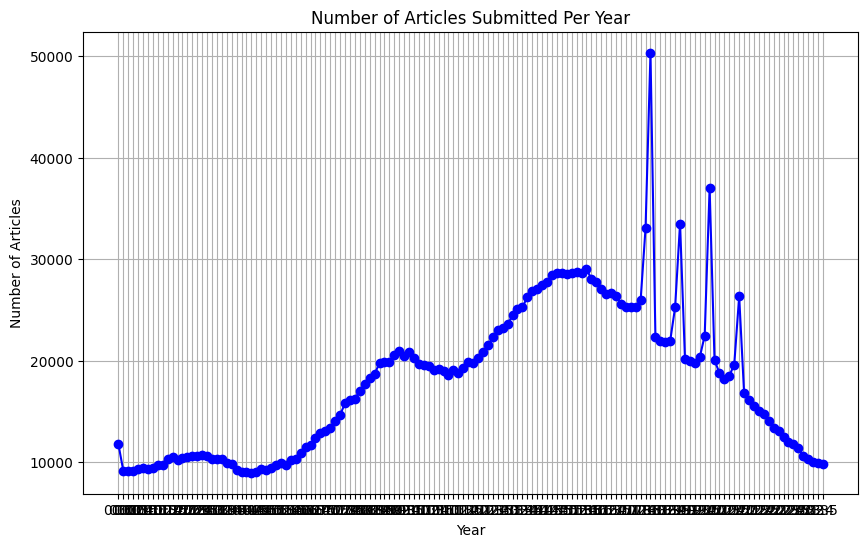

In [34]:
# Part 5: Time series of the number of articles per year
# Correctly extract the year from the 'versions' field
def extract_year(record):
    # Extract the first 'created' field from the 'versions' list
    created_date = record['versions'][0]['created']
    return created_date[-12:-8]  # Extract the year from the date string
    
# Compute yearly article counts
yearly_counts = parsed_rdd.map(lambda x: (extract_year(x), 1)) \
                          .filter(lambda x: x[0] is not None) \
                          .reduceByKey(lambda a, b: a + b) \
                          .collect()

# Sort by year for plotting
yearly_counts = sorted(yearly_counts, key=lambda x: x[0])
years, counts = zip(*yearly_counts)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='b')
plt.title("Number of Articles Submitted Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.grid()
plt.show()

In [36]:
# Part 6: Most frequent words in abstracts
# Define a function to extract and clean words from abstracts
def extract_and_clean_words(record):
    # Extract abstract, convert to lowercase, split into words, and clean text
    words = record['abstract'].lower().split()
    cleaned_words = [re.sub(r"[^a-zA-Z0-9]", "", word) for word in words]
    return [word for word in cleaned_words if word and word not in stopwords]

# Extract and clean words from all abstracts
abstract_words = parsed_rdd.flatMap(extract_and_clean_words)

# Count the frequency of each word
word_counts = abstract_words.map(lambda word: (word, 1)) \
                            .reduceByKey(lambda a, b: a + b)

# Get the top 20 most frequent words
most_frequent_words = word_counts.takeOrdered(20, key=lambda x: -x[1])

# Print the results
print("20 most frequent words in abstract:")
for word, count in most_frequent_words:
    print(word, ":", count)


20 most frequent words in abstract:
model : 1188676
data : 917131
results : 859049
show : 831879
using : 809828
also : 774216
two : 719284
models : 686537
paper : 650231
study : 596891
method : 596084
quantum : 573410
system : 559067
new : 550050
field : 544587
based : 527532
one : 518005
time : 506071
different : 497350
present : 477899


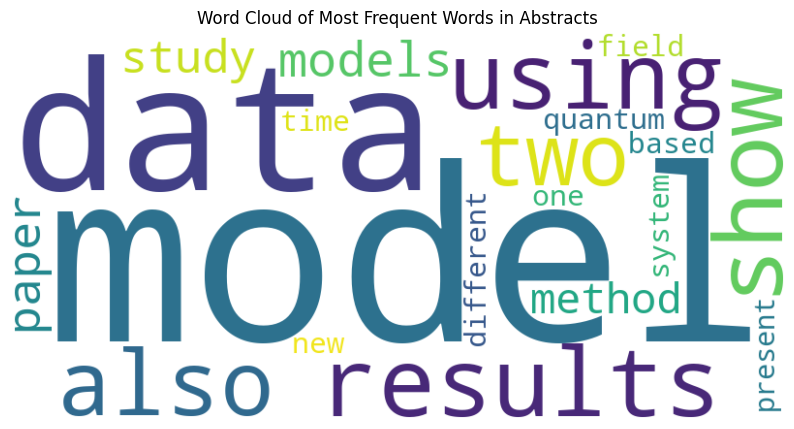

In [39]:
# Part 7: Word Cloud for the most frequent words
# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_frequent_words))

# Display the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words in Abstracts")
plt.show()

## Section 4: Advanced Data Exploration

- part 1: First, find articles that contain the word "algorithm" in their abstract.
- part 2: for these articles, count the number of words in each article's abstract.
- part 3: sort the articles by the word count in the abstract in descending order and display the top five articles with the highest word counts in their abstract.

In [27]:
# Part 1: Filter articles containing the word "algorithm" in their abstract
def contains_algorithm(record):
    return 'algorithm' in record['abstract'].lower()

algorithm_articles_rdd = parsed_rdd.filter(contains_algorithm)

In [28]:
# Part 2: Count the number of words in each article's abstract
def count_words(record):
    return len(record['abstract'].split())

word_count_rdd = algorithm_articles_rdd.map(lambda x: (x['title'], count_words(x)))

In [29]:
# Part 3: Sort by word count in descending order and display the top 5 articles
top_articles = word_count_rdd.sortBy(lambda x: x[1], ascending=False).take(5)

# Display the results
print("Top 5 articles with the highest word counts in their abstract (containing 'algorithm'):")
for title, word_count in top_articles:
    print(f"Title: {title}, Word Count: {word_count}")

Top 5 articles with the highest word counts in their abstract (containing 'algorithm'):
Title: The Nonlinearity Coefficient - A Practical Guide to Neural Architecture
  Design, Word Count: 498
Title: Generating a Generic Fluent API in Java, Word Count: 488
Title: Boxicity and Poset Dimension, Word Count: 484
Title: An Anytime Algorithm for Optimal Coalition Structure Generation, Word Count: 484
Title: McMini: A Programmable DPOR-Based Model Checker for Multithreaded
  Programs, Word Count: 475
